In [110]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.model_selection import StratifiedShuffleSplit

# Understanding Data

Memahami data ini bertujuan untuk mendapatkan insight-insight baru terhadap data.

In [2]:
anime_df = pd.read_csv("dataset/anime.csv")
rating_df = pd.read_csv("dataset/rating.csv")

## Deskripsi Data

Pada file Anime.csv, terdapat variabel-variabel sebagai berikut:

- anime_id : Merupakan identifier unik film anime.
- name : Merupakan judul lengkap anime.
- genre : Merupakan genre anime.
- type : Merupakan jenis anime (OVA, TV, Movie).
- episodes : Merupakan jumlah episode anime tersebut.
- rating : Merupakan rerata nilai yang didapatkan anime tersebut.
- members : Jumlah anggota yang berada pada "grup" anime tersebut.

In [3]:
anime_df.head(10)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
9,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109


Pada file Rating.csv, terdapat variabel-variabel sebagai berikut:

- user_id : Merupakan identifier yang dibuat secara random sebagai user_id.
- anime_id : Merupakan identifier anime yang diberikan nilai oleh pengguna.
- rating : Merupakan nilai yang diberikan oleh pengguna, memiliki skala hingga 10 serta nilai -1 jika user menonton dan tidak memberikan rating.

In [4]:
rating_df.head(10)

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
5,1,355,-1
6,1,356,-1
7,1,442,-1
8,1,487,-1
9,1,846,-1


## Memeriksa Jumlah Data

Berdasarkan hipotesis solusi yang diajukan menggunakan pendekatan *Collaborative Filtering* maka fitur-fitur yang akan diperiksa adalah sebagai berikut.
1. Jumlah seluruh data penilaian terhadap *anime*
2. Jumlah user identifier
3. Jumlah anime identifier

In [5]:
print("Jumlah seluruh data penilaian anime: {}".format(len(rating_df["user_id"])))
print("Jumlah identifier unik user: {}".format(len(rating_df["user_id"].unique())))
print("Jumlah identifier unik anime: {}".format(len(anime_df["anime_id"].unique())))

Jumlah seluruh data penilaian anime: 7813737
Jumlah identifier unik user: 73515
Jumlah identifier unik anime: 12294


## Memeriksa Keadaan Data

Memeriksa keadaan dataset apakah terdapat *Missing Value*.

In [6]:
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [7]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [8]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

# Data Cleaning

## Mengatasi Anime yang Tidak Diberi Nilai

Berdasarkan metadata singkat dataset, terdapat rating -1 yang berarti pengguna menonton *anime* tersebut namun tidak menilai *anime* tersebut. Hal ini akan menjadi masalah, karena kita tidak mengetahui apakah pengguna tersebut menyukai *anime* tersebut. 

In [10]:
len(rating_df[rating_df["rating"] == -1])

1476496

In [11]:
len(rating_df[rating_df["rating"] == -1]) / len(rating_df) * 100

18.896156858107716

In [49]:
neg_rating = rating_df[rating_df["rating"] == -1]
pos_rating = rating_df[rating_df["rating"] != -1]

print("Jumlah data yang memiliki poitif rating: {}".format(len(pos_rating)))
print("Jumlah data yang memiliki negatif rating: {}".format(len(neg_rating)))
print("Jumlah identifier unik pada data negatif rating: {}".format(len(neg_rating["anime_id"].unique())))

Jumlah data yang memiliki poitif rating: 6337241
Jumlah data yang memiliki negatif rating: 1476496
Jumlah identifier unik pada data negatif rating: 10697


In [50]:
neg_rating.head(5)

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [65]:
merge_rating = neg_rating.merge(anime_df, on="anime_id")

merge_rating = merge_rating[["user_id", "anime_id", "rating_y"]]
print("Panjang sebelum menghilangkan missing value: {}".format(len(merge_rating["anime_id"].unique())))

merge_rating = merge_rating.dropna(subset=["rating_y"])
print("Panjang setelah menghilangkan missing value: {}".format(len(merge_rating["anime_id"].unique())))

merge_rating["rating_y"] = merge_rating["rating_y"].astype("int64")
print("Merubah tipe data rating_y dari float menjadi int!")

Panjang sebelum menghilangkan missing value: 10694
Panjang setelah menghilangkan missing value: 10693
Merubah tipe data rating_y dari float menjadi int!


In [66]:
merge_rating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1476487 entries, 0 to 1476487
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype
---  ------    --------------    -----
 0   user_id   1476487 non-null  int64
 1   anime_id  1476487 non-null  int64
 2   rating_y  1476487 non-null  int64
dtypes: int64(3)
memory usage: 45.1 MB


In [67]:
merge_rating = merge_rating.rename(columns={"rating_y":"rating"})

In [68]:
prepared_df = pd.concat([pos_rating, merge_rating], ignore_index=True)

print("Jumlah data setelah dilakukan penggabungan data {}".format(len(prepared_df)))

Jumlah data setelah dilakukan penggabungan data 7813728


In [69]:
prepared_df.head(10)

,user_id,anime_id,rating
0,1,8074,10
1,1,11617,10
2,1,11757,10
3,1,15451,10
4,2,11771,10
5,3,20,8
6,3,154,6
7,3,170,9
8,3,199,10
9,3,225,9


# Eksplorasi Data: Univariate Analysis

Memvisualisasikan ketersebaran rating terhadap jumlah data yang ada.

### Melihat Ketersebaran Data Rating

<AxesSubplot:title={'center':'Distribution of Rating'}, xlabel='rating'>

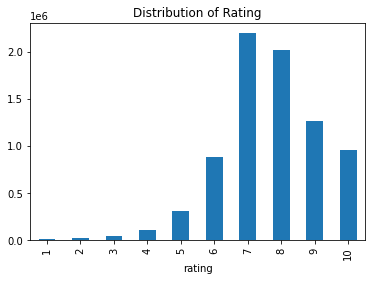

In [77]:
prepared_df.groupby("rating").size().plot(kind="bar", title="Distribution of Rating")

In [76]:
prepared_df["rating"].value_counts() / len(prepared_df) * 100

7     28.140729
8     25.842594
9     16.196430
10    12.231229
6     11.252887
5      3.918910
4      1.363792
3      0.541227
2      0.299089
1      0.213112
Name: rating, dtype: float64

# Data Preparation

Mempersiapkan data dimulai dari:
1. Pembuatan dictionary encoded baru
2. Split data menjadi training dan testing

### Encode User_id dan Anime_id

Meng-encode fitur user_id dan anime_id menjadi indeks integer. Hal ini dilakukan karena dua hal:
1. Sebagai look up dictionary
2. Indeks row embedding nantinya akan mengikuti indeks ini

In [85]:
encoded_df = prepared_df.copy()

Meng-encode menggunakan metode pandas .cat dan .codes. Kolom yang akan di-return indeks dari kolom tersebut.

In [86]:
encoded_df["user_id"] = encoded_df["user_id"].astype("category") 
encoded_df["user_id_encoded"] = encoded_df["user_id"].cat.codes

encoded_df["anime_id"] = encoded_df["anime_id"].astype("category")
encoded_df["anime_id_encoded"] = encoded_df["anime_id"].cat.codes

In [95]:
print("Jumlah user_id: {}".format(len(encoded_df["user_id"].unique())))
print("Jumlah hasil encoded user_id: {}".format(len(encoded_df["user_id_encoded"].unique())))
print()
print("Jumlah anime_id: {}".format(len(encoded_df["anime_id"].unique())))
print("Jumlah hasil encoded anime_id: {}".format(len(encoded_df["anime_id_encoded"].unique())))

Jumlah user_id: 73515
Jumlah hasil encoded user_id: 73515

Jumlah anime_id: 11197
Jumlah hasil encoded anime_id: 11197


In [96]:
encoded_df.sort_values("user_id_encoded").head(10)

,user_id,anime_id,rating,user_id_encoded,anime_id_encoded
0,1,8074,10,0,5214
6457115,1,14967,7,0,7190
6458667,1,15117,7,0,7214
6459339,1,15437,7,0,7253
6459958,1,15583,7,0,7275
6461788,1,15609,6,0,7279
6462044,1,16011,7,0,7357
6456073,1,14833,7,0,7175
6462947,1,16498,8,0,7439
6468225,1,17265,8,0,7614


In [97]:
encoded_df.sort_values("anime_id_encoded").head(10)

,user_id,anime_id,rating,user_id_encoded,anime_id_encoded
3856156,45525,1,8,45524,0
6620788,11924,1,8,11923,0
6620789,11974,1,8,11973,0
6620790,12007,1,8,12006,0
6620791,12050,1,8,12049,0
6620792,12136,1,8,12135,0
6620793,12154,1,8,12153,0
1631534,19502,1,10,19501,0
6620794,12222,1,8,12221,0
6620795,12254,1,8,12253,0


### Membangun dictionary sebagai lookup table

In [145]:
user_id_decoder = dict(zip(encoded_df["user_id_encoded"], encoded_df["user_id"]))
anime_id_decoder = dict(zip(encoded_df["anime_id_encoded"], encoded_df["anime_id"]))

user_id_encoder = dict(zip(encoded_df["user_id"], encoded_df["user_id_encoded"]))
anime_id_encoder = dict(zip(encoded_df["anime_id"], encoded_df["anime_id_encoded"]))

### Splitting Data dan Feature Scaling

Splitting data dengan membagi data sesuai representasi keseluruhan data

In [111]:
encoded_prep_df = encoded_df[["user_id_encoded", "anime_id_encoded", "rating"]]

split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in split.split(encoded_prep_df, encoded_prep_df["rating"]):
    strat_train_set = encoded_prep_df.loc[train_index]
    strat_test_set = encoded_prep_df.loc[test_index]

Hasil pembagian data secara strata

In [113]:
strat_train_set.groupby("rating").size() / len(strat_train_set) * 100

rating
1      0.213115
2      0.299089
3      0.541227
4      1.363796
5      3.918915
6     11.252888
7     28.140730
8     25.842595
9     16.196424
10    12.231223
dtype: float64

In [115]:
strat_test_set.groupby("rating").size() / len(strat_test_set) * 100

rating
1      0.213086
2      0.299089
3      0.541227
4      1.363753
5      3.918871
6     11.252884
7     28.140722
8     25.842587
9     16.196490
10    12.231290
dtype: float64

In [116]:
X_train = strat_train_set[["user_id_encoded", "anime_id_encoded"]].to_numpy()
y_train = strat_train_set["rating"].to_numpy()
y_train = (y_train - min(y_train)) / (max(y_train) - min(y_train))

X_test = strat_test_set[["user_id_encoded", "anime_id_encoded"]].to_numpy()
y_test = strat_test_set["rating"].to_numpy()
y_test = (y_test - min(y_test)) / (max(y_test) - min(y_test))

### Hasil Data Preparation dalam bentuk Numpy

In [117]:
print(X_train, y_train)

[[64750  8853]
 [45299  3752]
 [64540 10883]
 ...
 [28562  6216]
 [ 7132   278]
 [48029  2703]] [0.55555556 1.         0.77777778 ... 0.77777778 0.88888889 0.77777778]


# Modelling Data

Pada bagian ini akan dilakukan modelling menggunakan pendekatan Deep Learning:
1. RecommenderNet
2. Probabilistic Matrix Factorization

In [125]:
## Global Variable

NUM_USERS = len(user_id_dict)
NUM_ITEMS = len(anime_id_dict)
EMBEDDING_SIZE = 100

## RecommenderNet

In [133]:
class RecommenderNet(tf.keras.Model):
    def __init__(self, n_users, n_items, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.n_users = n_users
        self.n_items = n_items
        self.embedding_size = embedding_size
        
        self.user_embedding = keras.layers.Embedding(n_users,
                                                     embedding_size,
                                                     embeddings_initializer = 'he_normal',
                                                     embeddings_regularizer = keras.regularizers.l2(1e-6))
        
        self.user_bias = keras.layers.Embedding(n_users, 1)
        
        self.items_embedding = keras.layers.Embedding(n_items,
                                                      embedding_size,
                                                      embeddings_initializer = 'he_normal',
                                                      embeddings_regularizer = keras.regularizers.l2(1e-6))
        self.items_bias = keras.layers.Embedding(n_items, 1)
    
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:,0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.items_embedding(inputs[:, 1])
        item_bias = self.items_bias(inputs[:, 1])

        dot_user_resto = tf.tensordot(user_vector, item_vector, 2) 

        x = dot_user_resto + user_bias + item_bias

        return tf.nn.sigmoid(x)

In [136]:
recommender_net = RecommenderNet(NUM_USERS, NUM_ITEMS, EMBEDDING_SIZE)

recommender_net.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                        metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
recommender_net_hist = recommender_net.fit(X_train, y_train,
                                           epochs=5,
                                           validation_data=(X_test, y_test))

## Probabilistic Matrix Factorization

In [140]:
class PMF(tf.keras.Model):
    def __init__(self, n_users, n_items, n_dim):
        super(PMF, self).__init__()      
        self.w_u_i_init = tf.keras.initializers.RandomUniform(minval=-1., maxval=1., seed=1)
        
        self.user_embedding = tf.keras.layers.Embedding(n_users,
                                                        n_dim,
                                                        embeddings_initializer='uniform',
                                                        embeddings_regularizer=tf.keras.regularizers.L2(0.1))
      
        self.item_embedding = tf.keras.layers.Embedding(n_items,
                                                        n_dim,
                                                        embeddings_initializer='uniform',
                                                        embeddings_regularizer=tf.keras.regularizers.L2(0.1))
        
        ## users embedding
        self.ub = tf.keras.layers.Embedding(n_users, 
                                            1, 
                                            embeddings_initializer=self.w_u_i_init, 
                                            embeddings_regularizer=tf.keras.regularizers.L2(0.1)) 
        ## items embedding
        self.ib = tf.keras.layers.Embedding(n_items, 
                                            1, 
                                            embeddings_initializer=self.w_u_i_init, 
                                            embeddings_regularizer=tf.keras.regularizers.L2(0.1))
        
    def call(self, inputs):
        self.user_index = inputs[:, 0]
        self.item_index = inputs[:, 1]
        
        user_h1 = self.user_embedding(self.user_index)
        item_h1 = self.item_embedding(self.item_index)
        
        r_h = tf.math.reduce_sum(user_h1 * item_h1, axis=1 if len(user_h1.shape) > 1 else 0)
        r_h += tf.squeeze(self.ub(self.user_index))
        r_h += tf.squeeze(self.ib(self.item_index))
        
        return r_h

In [143]:
pmf = PMF(NUM_USERS, NUM_ITEMS, EMBEDDING_SIZE)

pmf.compile(loss='mse',
            optimizer='Nadam',
            metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
pmf_hist = pmf.fit(X_train, y_train,
                   epochs=100,
                   validation_data=(X_test, y_test))